In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 적용
plt.rc('font', family='Malgun Gothic') 
# 캔버스 사이즈 적용
plt.rcParams["figure.figsize"] = (12, 9)


from hanspell import spell_checker
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('../input/train.csv', dtype=str)
valid = pd.read_csv('../input/validation.csv', dtype=str)
test = pd.read_csv('../input/test.csv', dtype=str)


In [3]:
print(train.info(), "\n")
print(valid.info(), "\n")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65299 entries, 0 to 65298
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  65299 non-null  object
 1   intent     65299 non-null  object
dtypes: object(2)
memory usage: 1020.4+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10872 entries, 0 to 10871
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  10872 non-null  object
 1   intent     10872 non-null  object
dtypes: object(2)
memory usage: 170.0+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8481 entries, 0 to 8480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  8481 non-null   object
 1   intent     8481 non-null   object
dtypes: object(2)
memory usage: 132.6+ KB
None


In [4]:
dfs = { 
    'train': {
        'data' : train
    }, 
    'valid': {
        'data' : valid
    } , 
    'test': {
        'data' : test
    } 
}

### 전처리

In [5]:
# na값 확인
print(train.isna().values.any())
print(valid.isna().values.any())
print(test.isna().values.any())

False
False
False


In [6]:
# 결측치 확인 및 제거
for dfName in dfs.keys():
    # 빈값 제거 
    print(len(dfs[dfName]['data']))
    dfs[dfName]['data'].replace("", float("NaN"), inplace=True)
    dfs[dfName]['data'].dropna(inplace=True)
    print(dfs[dfName]['data'].isnull().values.any())
    print(len(dfs[dfName]['data']))
    
    print("\n")

65299
False
65299


10872
False
10872


8481
False
8481




In [7]:
print('중복을 제외한 train의 utterance  : {}'.format(train['utterance'].nunique()))
print('중복을 제외한 train의 intent     : {}'.format(train['intent'].nunique()))
print('중복을 제외한 valid의 utterance  : {}'.format(valid['utterance'].nunique()))
print('중복을 제외한 valid의 intent     : {}'.format(valid['intent'].nunique()))
print('중복을 제외한 test의 utterance  : {}'.format(test['utterance'].nunique()))
print('중복을 제외한 test의 intent     : {}'.format(test['intent'].nunique()))

중복을 제외한 train의 utterance  : 65284
중복을 제외한 train의 intent     : 13
중복을 제외한 valid의 utterance  : 10872
중복을 제외한 valid의 intent     : 13
중복을 제외한 test의 utterance  : 8481
중복을 제외한 test의 intent     : 13


In [8]:
train['intent'].value_counts().sort_values(ascending=False)

제품          41635
배송          15744
교환|반품|환불     2431
행사           1895
결제           1214
AS            839
구매            423
웹사이트          303
부가서비스         269
포장            253
매장            202
주문             53
멤버십            38
Name: intent, dtype: int64

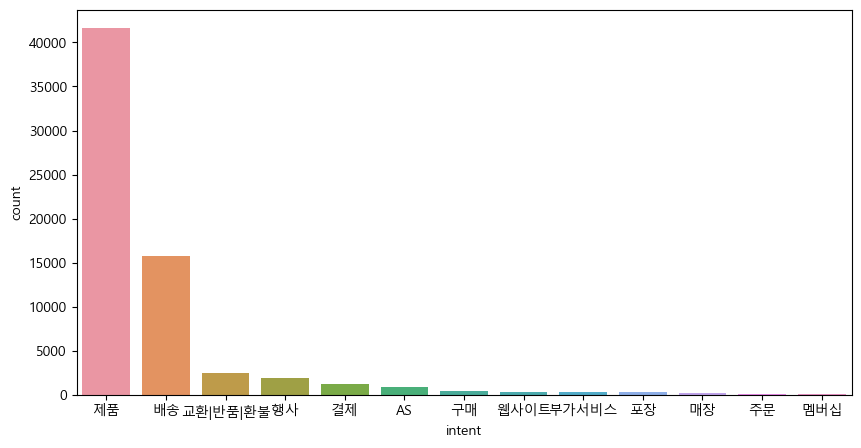

In [9]:
order = train['intent'].value_counts().sort_values(ascending=False).index

fig = plt.figure(figsize=(10,5))
sns.countplot(data = train, x = 'intent', order=order)
plt.show()

# target이 비율이 다름 

### 토큰화 전 맞춤법 보정

In [10]:
# 맞춤법 보정
def spellCheck(sent):
    sent = sent.replace(" ", "")
    spelled_sent = spell_checker.check(sent)
    hanspell_sent = spelled_sent.checked
    return hanspell_sent

In [11]:
sent = train['utterance'][65296]
nsSent = sent.replace(" ", "")

print("nsSent               : ", nsSent)

spelled_sent = spell_checker.check(sent)
hanspell_sent = spelled_sent.checked
print("hanspell_sent        : ", hanspell_sent)

nsSent               :  세트구성에는4060이던데그사이즈는필요없어서5070으로일단추가구매했는데둘다보내는건가여?
hanspell_sent        :  세트 구성에는 40 60이던데 그 사이즈는 필요 없어서 50 70으로 일단 추가 구매했는데 둘 다 보내는 건가요?


#### 정수 인코딩 

In [13]:
# 라벨 인코더 생성
encoder = LabelEncoder()
train_intent = train['intent']
valid_intent = valid['intent']
test_intent = test['intent']

# X_train데이터를 이용 피팅하고 라벨숫자로 변환한다
encoder.fit(train_intent)
X_train_encoded = encoder.transform(train_intent)

# X_test데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가한다 (중요!!!)
for item in [np.unique(valid_intent), np.unique(test_intent)]:
    for label in item:
        if label not in encoder.classes_: # unseen label 데이터인 경우( )
            encoder.classes_ = np.append(encoder.classes_, label) # 미처리 시 ValueError발생
X_valid_encoded = encoder.transform(valid_intent)
X_test_encoded = encoder.transform(test_intent)


In [14]:
train['target'] = X_train_encoded
valid['target'] = X_valid_encoded
test['target'] = X_test_encoded

In [281]:
# set max length for warning about local memory
max_point = 20
max_train_len = int(len(train)/max_point)
max_valid_len = int(len(valid)/max_point)
max_test_len = int(len(test)/max_point)


train_utterance = train['utterance'][:max_train_len]
train_label = train['target'][:max_train_len]
valid_utterance = valid['utterance'][:max_valid_len]
valid_label = valid['target'][:max_valid_len]
test_utterance = test['utterance'][:max_test_len]
test_label = test['target'][:max_test_len]

vocab_size = int(len(train) / max_point * 10 * 0.8) # 임의로 적용
num_classes = train['target'].nunique()

# train_utterance = train['utterance']
# train_label = train['target']
# valid_utterance = valid['utterance']
# valid_label = valid['target']
# test_utterance = test['utterance']
# test_label = test['target']

# vocab_size = int(40000 / max_point)
# num_classes = train['target'].nunique()

In [26]:
vocab_size

2611

#### 토큰화

In [ ]:
# from soynlp.tokenizer import LTokenizer 버전2에서 적용

In [57]:

tokenizer = Tokenizer(num_words = vocab_size) # vocab_size 개수만큼의 단어만 사용한다.
tokenizer.fit_on_texts(train_utterance)

In [69]:
temp = tokenizer.texts_to_sequences(train_utterance)
for i in temp:
    if len(i) < 1:
        print(i)

In [282]:
tokenizer = Tokenizer(num_words = vocab_size) # vocab_size 개수만큼의 단어만 사용한다.
tokenizer.fit_on_texts(train_utterance)
X_train = tokenizer.texts_to_sequences(train_utterance) # 샘플 수 × vocab_size 크기의 행렬 생성
X_valid = tokenizer.texts_to_sequences(valid_utterance) # 샘플 수 × vocab_size 크기의 행렬 생성
X_test = tokenizer.texts_to_sequences(test_utterance) # 샘플 수 × vocab_size 크기의 행렬 생성
y_train = train_label
y_valid = valid_label
y_test = test_label

In [84]:
len(tokenizer.word_index)

10409

In [283]:
print('train 샘플 본문의 크기 : {}'.format(len(X_train)))
print('train 샘플 레이블의 크기 : {}'.format(len(y_train)))
print('valid 샘플 본문의 크기 : {}'.format(len(X_valid)))
print('valid 샘플 레이블의 크기 : {}'.format(len(y_valid)))
print('test  샘플 본문의 크기 : {}'.format(len(X_test)))
print('test  샘플 레이블의 크기 : {}'.format(len(y_test)))


train 샘플 본문의 크기 : 3264
train 샘플 레이블의 크기 : 3264
valid 샘플 본문의 크기 : 543
valid 샘플 레이블의 크기 : 543
test  샘플 본문의 크기 : 424
test  샘플 레이블의 크기 : 424


In [79]:
X_train[0]

[2594, 2595, 12, 151, 236, 9]

In [86]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[    0     1     2     3     4     5     6     7     8     9    10    11
     12]
 [  839  1214  2431   423   202    38 15744   269   303 41635    53   253
   1895]]


In [87]:
encoder.classes_

array(['AS', '결제', '교환|반품|환불', '구매', '매장', '멤버십', '배송', '부가서비스', '웹사이트',
       '제품', '주문', '포장', '행사'], dtype=object)

In [93]:
encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

array(['AS', '결제', '교환|반품|환불', '구매', '매장', '멤버십', '배송', '부가서비스', '웹사이트',
       '제품', '주문', '포장', '행사'], dtype=object)

sentence의 최대 길이 :39
sentence의 평균 길이 :7.998468137254902


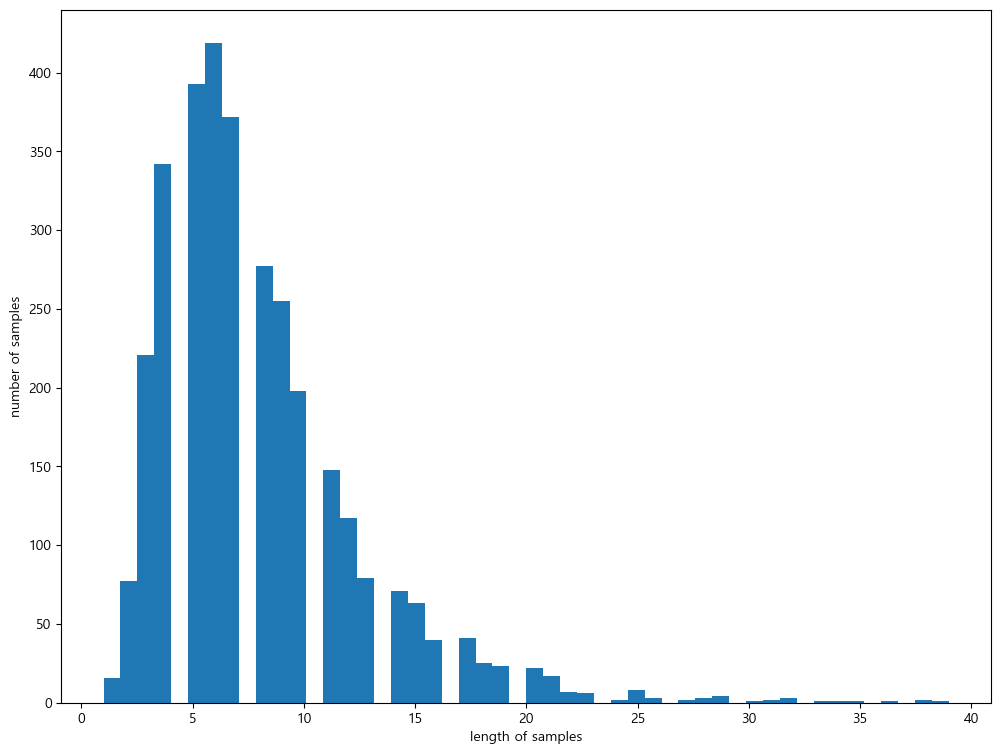

In [118]:
max_len = max(len(sample) for sample in X_train)
print('sentence의 최대 길이 :{}'.format(max_len))
print('sentence의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(sample) for sample in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


#### modeling

In [284]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras import backend as K


vocab_size = vocab_size
max_len = max_len

X_train = pad_sequences(X_train, maxlen=max_len)
X_valid = pad_sequences(X_valid, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)


In [276]:
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score


In [286]:
X_train.shape

(3264, 39)

In [287]:
y_train.shape

(3264, 13)

In [124]:
embedding_dim = 128
hidden_units = 128
num_classes = num_classes

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_valid, y_valid))


Epoch 1/30
26/26 [==============================] - ETA: 0s - loss: 1.5776 - acc: 0.6075
Epoch 1: val_acc improved from -inf to 0.69429, saving model to best_model.h5
26/26 [==============================] - 5s 125ms/step - loss: 1.5776 - acc: 0.6075 - val_loss: 1.0502 - val_acc: 0.6943
Epoch 2/30
26/26 [==============================] - ETA: 0s - loss: 1.1233 - acc: 0.6275
Epoch 2: val_acc did not improve from 0.69429
26/26 [==============================] - 2s 86ms/step - loss: 1.1233 - acc: 0.6275 - val_loss: 1.0302 - val_acc: 0.6943
Epoch 3/30
26/26 [==============================] - ETA: 0s - loss: 1.0179 - acc: 0.6670
Epoch 3: val_acc improved from 0.69429 to 0.77164, saving model to best_model.h5
26/26 [==============================] - 2s 86ms/step - loss: 1.0179 - acc: 0.6670 - val_loss: 0.8678 - val_acc: 0.7716
Epoch 4/30
26/26 [==============================] - ETA: 0s - loss: 0.6990 - acc: 0.8208
Epoch 4: val_acc improved from 0.77164 to 0.78453, saving model to best_model.

In [301]:
embedding_dim = 128
hidden_units = 256
num_classes = num_classes
batch_size = 128
epochs = 30
verbose = 1

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', precision, recall, f1score])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[es, mc], validation_data=(X_valid, y_valid))


Epoch 1/30
26/26 [==============================] - ETA: 0s - loss: 1.4403 - acc: 0.5699 - precision: 0.4292 - recall: 0.4288 - f1score: 0.4290
Epoch 1: val_acc improved from -inf to 0.69429, saving model to best_model.h5
26/26 [==============================] - 12s 346ms/step - loss: 1.4403 - acc: 0.5699 - precision: 0.4292 - recall: 0.4288 - f1score: 0.4290 - val_loss: 1.0765 - val_acc: 0.6943 - val_precision: 0.6917 - val_recall: 0.6917 - val_f1score: 0.6917
Epoch 2/30
26/26 [==============================] - ETA: 0s - loss: 1.1176 - acc: 0.6275 - precision: 0.6282 - recall: 0.6271 - f1score: 0.6277
Epoch 2: val_acc did not improve from 0.69429
26/26 [==============================] - 12s 471ms/step - loss: 1.1176 - acc: 0.6275 - precision: 0.6282 - recall: 0.6271 - f1score: 0.6277 - val_loss: 1.0125 - val_acc: 0.6943 - val_precision: 0.7051 - val_recall: 0.6917 - val_f1score: 0.6983
Epoch 3/30
26/26 [==============================] - ETA: 0s - loss: 0.9694 - acc: 0.7034 - precision

#### evaluate

In [302]:
_loss, _acc, _precision, _recall, _f1score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _precision, _recall, _f1score))

4/4 [==============================] - 0s 83ms/step - loss: 1.1007 - acc: 0.7594 - precision: 0.8424 - recall: 0.6938 - f1score: 0.7608
loss: 1.101, accuracy: 0.759, precision: 0.842, recall: 0.694, f1score: 0.761


In [254]:
y_pred = model.predict([X_test], batch_size=batch_size)
y_pred

4/4 [==============================] - 0s 88ms/step


array([[8.08731129e-04, 4.73544264e-04, 1.08459935e-04, ...,
        2.79450414e-05, 2.99061940e-04, 2.53587961e-04],
       [5.08387748e-04, 1.87768042e-03, 2.79546191e-04, ...,
        5.84390800e-05, 3.66591645e-04, 5.71241428e-04],
       [1.26414113e-02, 3.92735526e-02, 1.83999874e-02, ...,
        2.96644913e-03, 1.02178510e-02, 4.34855893e-02],
       ...,
       [8.96691228e-04, 1.24653149e-03, 2.56769301e-04, ...,
        6.60512451e-05, 5.15443331e-04, 5.63142705e-04],
       [1.40498264e-03, 4.40297369e-03, 7.69922044e-04, ...,
        1.95308879e-04, 1.04760879e-03, 1.88842230e-03],
       [7.59547902e-06, 1.76862886e-04, 3.10115516e-04, ...,
        1.48608842e-06, 4.46240665e-06, 1.56739945e-04]], dtype=float32)

In [241]:
y_test2 = np.argmax(y_test, axis=1)

In [247]:
y_pred.tolist()

[9,
 9,
 6,
 6,
 9,
 9,
 6,
 6,
 9,
 6,
 9,
 9,
 6,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 6,
 6,
 9,
 9,
 6,
 6,
 6,
 9,
 9,
 6,
 9,
 9,
 9,
 9,
 6,
 6,
 6,
 9,
 9,
 9,
 9,
 9,
 9,
 12,
 9,
 9,
 2,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 6,
 9,
 6,
 6,
 9,
 6,
 9,
 9,
 9,
 9,
 6,
 9,
 9,
 1,
 9,
 9,
 9,
 9,
 6,
 9,
 9,
 6,
 9,
 9,
 6,
 9,
 9,
 9,
 9,
 6,
 9,
 9,
 6,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 9,
 6,
 9,
 9,
 0,
 9,
 6,
 9,
 9,
 6,
 9,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 6,
 6,
 6,
 6,
 6,
 9,
 9,
 9,
 12,
 9,
 9,
 6,
 9,
 9,
 9,
 6,
 6,
 9,
 12,
 9,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 6,
 9,
 9,
 9,
 6,
 9,
 9,
 9,
 6,
 6,
 9,
 9,
 6,
 9,
 9,
 6,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 6,
 9,
 9,
 9,
 6,
 9,
 9,
 9,
 6,
 9,
 9,
 6,
 6,
 9,
 9,
 2,
 6,
 9,
 6,
 9,
 2,
 9,
 9,
 6,
 9,
 6,
 12,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 6,
 9,
 9,
 9,
 9,
 6,
 9,
 9,
 6,
 6,
 6,
 6,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 6,
 9,
 9,
 6,
 9,
 6,
 9,
 9,
 6,
 9,
 6,
 9,
 6,
 6,
 9,
 9,
 12,
 9,
 6,
 9,
 9,
 9,

In [248]:
test_label.tolist()

[9,
 9,
 6,
 6,
 9,
 9,
 4,
 6,
 9,
 9,
 9,
 9,
 6,
 2,
 9,
 9,
 9,
 9,
 9,
 9,
 6,
 6,
 0,
 9,
 9,
 9,
 9,
 6,
 6,
 9,
 6,
 6,
 12,
 6,
 6,
 9,
 6,
 9,
 9,
 6,
 6,
 6,
 2,
 6,
 9,
 9,
 9,
 9,
 9,
 9,
 12,
 9,
 9,
 2,
 9,
 9,
 6,
 9,
 8,
 9,
 9,
 6,
 9,
 5,
 6,
 9,
 9,
 9,
 4,
 9,
 9,
 6,
 9,
 9,
 2,
 9,
 9,
 12,
 9,
 9,
 9,
 9,
 9,
 9,
 6,
 6,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 1,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 6,
 1,
 9,
 6,
 9,
 9,
 9,
 3,
 6,
 12,
 9,
 6,
 9,
 2,
 12,
 9,
 9,
 6,
 6,
 6,
 2,
 6,
 9,
 9,
 9,
 9,
 9,
 11,
 12,
 9,
 6,
 9,
 6,
 6,
 9,
 6,
 9,
 9,
 6,
 9,
 9,
 3,
 9,
 9,
 9,
 9,
 9,
 8,
 9,
 12,
 9,
 6,
 9,
 9,
 0,
 9,
 6,
 9,
 9,
 2,
 9,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 9,
 6,
 9,
 9,
 9,
 9,
 6,
 12,
 9,
 6,
 9,
 11,
 9,
 2,
 6,
 9,
 9,
 2,
 6,
 9,
 2,
 9,
 6,
 9,
 9,
 6,
 9,
 10,
 12,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 7,
 9,
 6,
 9,
 9,
 9,
 9,
 12,
 9,
 9,
 6,
 6,
 9,
 6,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 6,
 9,
 9,
 6,
 9,
 6,
 9,
 9,
 6,
 9,
 2,
 9,
 6,
 6,
 9,
 9,
 12,
 12,
 9,
 

In [225]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [256]:
np.vstack(y_pred)

array([[8.08731129e-04, 4.73544264e-04, 1.08459935e-04, ...,
        2.79450414e-05, 2.99061940e-04, 2.53587961e-04],
       [5.08387748e-04, 1.87768042e-03, 2.79546191e-04, ...,
        5.84390800e-05, 3.66591645e-04, 5.71241428e-04],
       [1.26414113e-02, 3.92735526e-02, 1.83999874e-02, ...,
        2.96644913e-03, 1.02178510e-02, 4.34855893e-02],
       ...,
       [8.96691228e-04, 1.24653149e-03, 2.56769301e-04, ...,
        6.60512451e-05, 5.15443331e-04, 5.63142705e-04],
       [1.40498264e-03, 4.40297369e-03, 7.69922044e-04, ...,
        1.95308879e-04, 1.04760879e-03, 1.88842230e-03],
       [7.59547902e-06, 1.76862886e-04, 3.10115516e-04, ...,
        1.48608842e-06, 4.46240665e-06, 1.56739945e-04]], dtype=float32)

In [ ]:
targets = np.vstack(targets)
pred_classes = np.vstack(pred_classes)


In [265]:
np.argmax(y_test, axis=1).tolist()

[9,
 9,
 6,
 6,
 9,
 9,
 4,
 6,
 9,
 9,
 9,
 9,
 6,
 2,
 9,
 9,
 9,
 9,
 9,
 9,
 6,
 6,
 0,
 9,
 9,
 9,
 9,
 6,
 6,
 9,
 6,
 6,
 12,
 6,
 6,
 9,
 6,
 9,
 9,
 6,
 6,
 6,
 2,
 6,
 9,
 9,
 9,
 9,
 9,
 9,
 12,
 9,
 9,
 2,
 9,
 9,
 6,
 9,
 8,
 9,
 9,
 6,
 9,
 5,
 6,
 9,
 9,
 9,
 4,
 9,
 9,
 6,
 9,
 9,
 2,
 9,
 9,
 12,
 9,
 9,
 9,
 9,
 9,
 9,
 6,
 6,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 1,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 6,
 1,
 9,
 6,
 9,
 9,
 9,
 3,
 6,
 12,
 9,
 6,
 9,
 2,
 12,
 9,
 9,
 6,
 6,
 6,
 2,
 6,
 9,
 9,
 9,
 9,
 9,
 11,
 12,
 9,
 6,
 9,
 6,
 6,
 9,
 6,
 9,
 9,
 6,
 9,
 9,
 3,
 9,
 9,
 9,
 9,
 9,
 8,
 9,
 12,
 9,
 6,
 9,
 9,
 0,
 9,
 6,
 9,
 9,
 2,
 9,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 9,
 6,
 9,
 9,
 9,
 9,
 6,
 12,
 9,
 6,
 9,
 11,
 9,
 2,
 6,
 9,
 9,
 2,
 6,
 9,
 2,
 9,
 6,
 9,
 9,
 6,
 9,
 10,
 12,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 7,
 9,
 6,
 9,
 9,
 9,
 9,
 12,
 9,
 9,
 6,
 6,
 9,
 6,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 6,
 9,
 9,
 6,
 9,
 6,
 9,
 9,
 6,
 9,
 2,
 9,
 6,
 6,
 9,
 9,
 12,
 12,
 9,
 

In [274]:
# target_names=unique_elements
# target_names=list(map(str,target_names))

print(classification_report(np.argmax(y_test, axis=1).tolist(), np.argmax(y_pred, axis=1).tolist(), target_names=encoder.classes_))

              precision    recall  f1-score   support

          AS       0.00      0.00      0.00         5
          결제       0.00      0.00      0.00         4
    교환|반품|환불       0.80      0.22      0.35        18
          구매       0.00      0.00      0.00         4
          매장       0.00      0.00      0.00         2
         멤버십       0.00      0.00      0.00         1
          배송       0.64      0.84      0.73        99
       부가서비스       0.00      0.00      0.00         2
        웹사이트       0.00      0.00      0.00         2
          제품       0.84      0.89      0.86       265
          주문       0.00      0.00      0.00         1
          포장       0.00      0.00      0.00         3
          행사       0.50      0.17      0.25        18

    accuracy                           0.77       424
   macro avg       0.21      0.16      0.17       424
weighted avg       0.73      0.77      0.74       424



C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [198]:
_precision = 0 
_recall = 0
_f1score = 0
_loss, _acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _precision, _recall, _f1score))


4/4 - 0s - loss: 1.1604 - acc: 0.7406 - 321ms/epoch - 80ms/step
loss: 1.160, accuracy: 0.741, precision: 0.000, recall: 0.000, f1score: 0.000


In [126]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       2594, 2595,   12,  151,  236,    9])

In [173]:
test.loc[0]

utterance    인스탁스 미니 25케이스 은 안 파나요?
intent                           제품
target                            9
Name: 0, dtype: object

In [183]:
temp = model.predict([X_test[3].tolist(),])
temp

1/1 [==============================] - 0s 58ms/step


array([[1.4532496e-03, 4.6627708e-03, 1.2882822e-03, 5.5378349e-04,
        2.4291624e-04, 8.1918151e-05, 9.7720033e-01, 6.2216271e-04,
        3.7310171e-04, 9.0112124e-05, 1.8234563e-04, 3.2110908e-04,
        1.2927997e-02]], dtype=float32)

In [185]:
list = [round(i) for i in temp[0]]
list

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

In [182]:
y_test[3]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

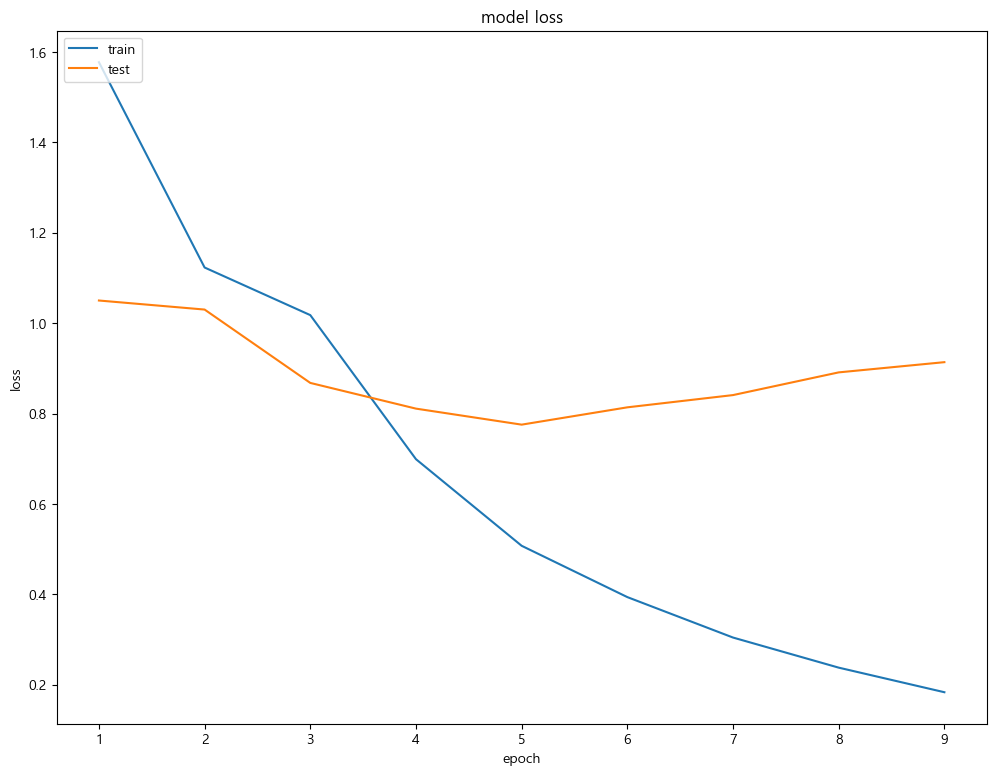

In [167]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
